In [1]:
import music21
import numpy as np
import glob
import matplotlib.pyplot as plt
import tqdm
import pickle

## Note vs. Offset

In [2]:
#we begin by looking at duration and its relation to offset.

In [3]:
def note_duration_vs_offset(filename):
    """For each chord or note event in the midi file, the function returns a 0 if the
    note's duration is equal to the next event's offset minus the current event's offset, a 1 if it is less,
    and a 2 if it is more"""
    #note stream is not neccesarily in order of increasing offset.
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes

    offsets=[]
    durations=[]

    for note in notesRaw:
        offsets.append(float(note.offset))
        durations.append(float(note.duration.quarterLength))

    SortedUniqueOffsets=list(set(offsets))
    SortedUniqueOffsets=np.array(SortedUniqueOffsets)
    SortedUniqueOffsets=np.sort(SortedUniqueOffsets)

    offsets=np.array(offsets)
    durations=np.array(durations)

    results=[]

    for i,UniqueOffset in enumerate(SortedUniqueOffsets):
        dursHere=durations[offsets==UniqueOffset]
        if i<len(SortedUniqueOffsets)-2:
            offsetDifference=SortedUniqueOffsets[i+1]-UniqueOffset

            for dur in dursHere:
                if dur==offsetDifference:
                    results.append(0)
                elif dur<offsetDifference:
                    results.append(1)
                else:
                    results.append(2)
    return results

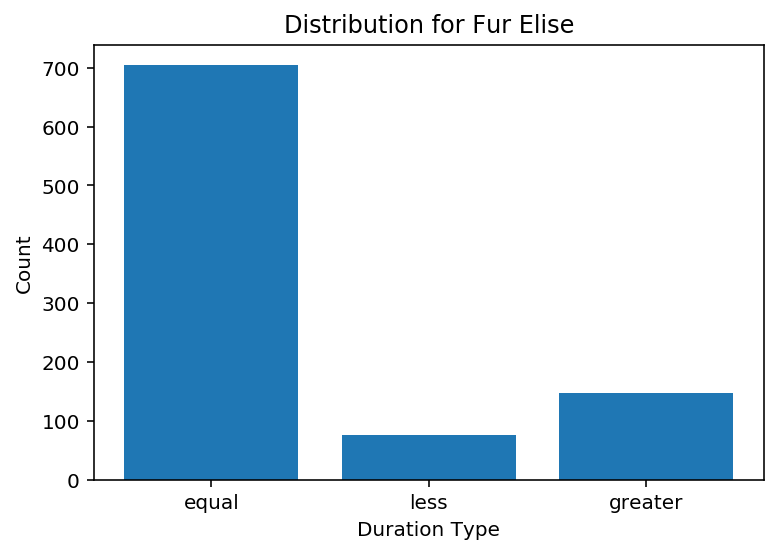

In [4]:
#we begin with Beethoven's Fur Elise:
results=note_duration_vs_offset('Music/beeth/elise.mid')
x,y=np.unique(results,return_counts=True)
plt.bar(x,y)
plt.xticks((0,1,2),('equal','less','greater'))
plt.title('Distribution for Fur Elise')
plt.xlabel('Duration Type')
plt.ylabel('Count')
plt.savefig('figures/furelise_durationDist.png')
plt.show()

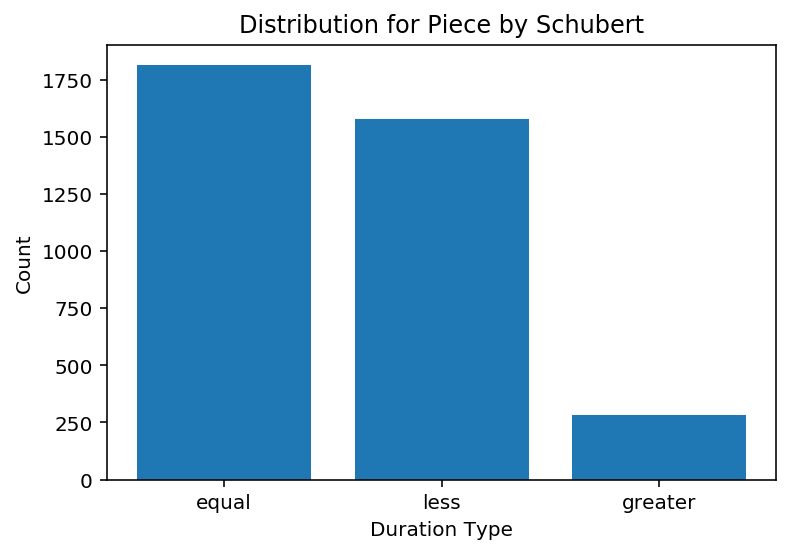

In [5]:
#next we look at a piece by Schubert:
results=note_duration_vs_offset('Music/schubert/schubert_D935_4.mid')
x,y=np.unique(results,return_counts=True)
plt.bar(x,y)
plt.xticks((0,1,2),('equal','less','greater'))
plt.title('Distribution for Piece by Schubert')
plt.xlabel('Duration Type')
plt.ylabel('Count')
plt.savefig('figures/schubert_durationDist.png')
plt.show()

In [2]:
#Finally we look at the distribution over all the pieces in the dataset:
#we begin by getting the filename of each song.

artists=glob.glob('Music/*') #files are sorted via artist

songs=[] #the song filename

for artist in artists:
    songs.extend(glob.glob(artist+'/*'))


100%|██████████| 266/266 [02:17<00:00,  1.13s/it]


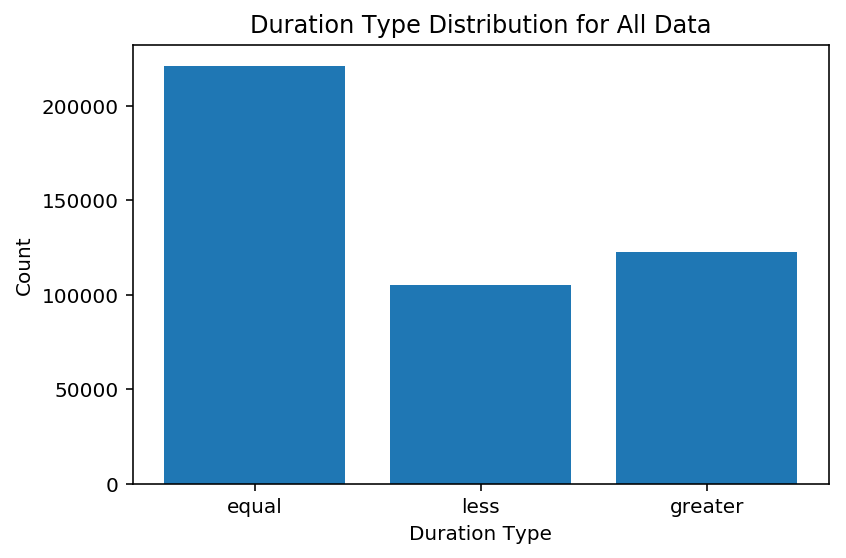

In [32]:
results=[]

for song in tqdm.tqdm(songs):
    resultHere=note_duration_vs_offset(song)
    results.extend(resultHere)

x,y=np.unique(results,return_counts=True)
plt.bar(x,y)
plt.xticks((0,1,2),('equal','less','greater'))
plt.title('Duration Type Distribution for All Data')
plt.xlabel('Duration Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/Entire_durationDist.png')
plt.show()

## Note Duration

In [ ]:
#we next look at the distribution of notes duration over all the dataset.

In [33]:
def note_durations(filename):
    """obtain duration of each note/chord in filename where filename is a midi file."""
    
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes

    durations=[]

    for note in notesRaw:
        durations.append(float(note.duration.quarterLength))

    return durations

In [13]:
durations=[]

for song in tqdm.tqdm(songs):
    durationHere=note_durations(song)
    durations.extend(durationHere)



100%|██████████| 266/266 [01:57<00:00,  1.04s/it]


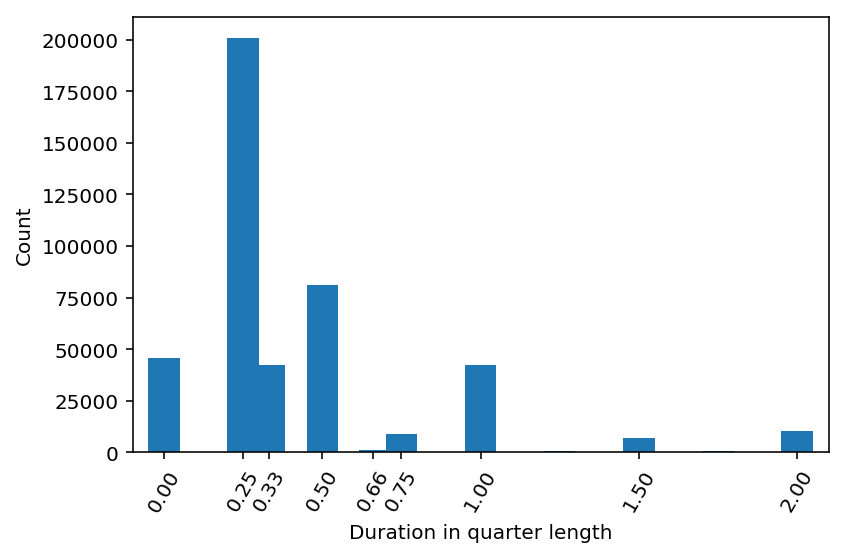

In [112]:
x,y=np.unique(durations,return_counts=True)
plt.bar(x,y,width=0.1)
plt.xlim((-0.1,2.1))
plt.xticks([0,0.25,0.33,0.5,0.66,0.75,1,1.5,2],rotation=60)
plt.xlabel('Duration in quarter length')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/quarterLengthDistributions.png',bbox_inches='tight')
plt.show()

In [106]:
yy=[]
for i,yhere in enumerate(y):
    if i>0:
        yy.append(yy[i-1]+yhere)
    else:
        yy.append(yhere)


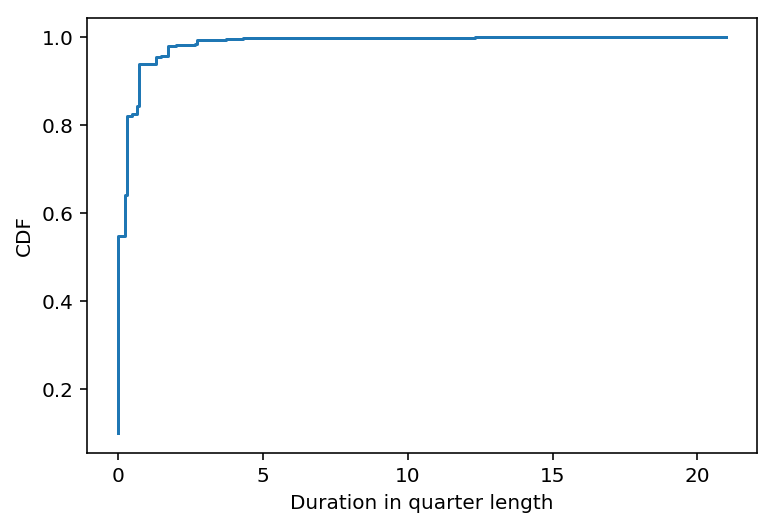

In [107]:
plt.step(x,yy/yy[-1])
plt.xlabel('Duration in quarter length')
plt.ylabel('CDF')
plt.savefig('figures/CDF_durs.png')
plt.show()

## Note Offsets


In [ ]:
#we next look at the distribution of offset differences

In [115]:
def song_offset_differences(filename):
    """obtain offset of each note/chord in filename where filename is a midi file."""
    
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes

    offsets=[]

    for note in notesRaw:
        offsets.append(float(note.offset))
        
    offsets=np.array(list(set(offsets)))
    offsets=np.sort(offsets)
    offsets=np.diff(offsets)

    return offsets

In [121]:
offsets=[]

for song in tqdm.tqdm(songs):
    offsetHere=song_offset_differences(song)
    offsets.extend(offsetHere)


100%|██████████| 266/266 [02:19<00:00,  1.23s/it]


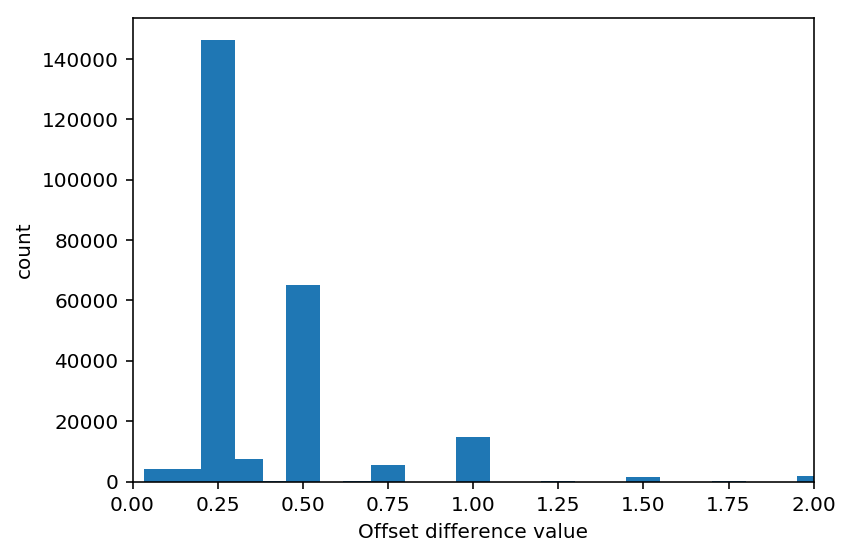

In [125]:
x,y=np.unique(offsets,return_counts=True)
plt.bar(x,y,width=0.1)
plt.xlim((0,2))
plt.xlabel('Offset difference value')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('figures/offset_diffs.png')
plt.show()


## Number of pitches per offset

In [3]:
#we next look at the distribution of number of pitches per offset

In [95]:
def pitches_per_offset(filename):
    """Returns a list of values where each value is the number of pitches played at each offset"""
    #note stream is not neccesarily in order of increasing offset.
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes

    offsets=[]
    numNotes=[]
    
    for note in notesRaw:
        offsets.append(float(note.offset))
        if isinstance(note,music21.note.Note):
            numNotes.append(1)
        else:
            chordNotes=[int(b.midi) for b in note.pitches]
            numNotes.append(len(chordNotes))
        
    SortedUniqueOffsets=list(set(offsets))
    SortedUniqueOffsets=np.array(SortedUniqueOffsets)
    SortedUniqueOffsets=np.sort(SortedUniqueOffsets)
    
    numNotes=np.array(numNotes)
    offsets=np.array(offsets)

    results=[]

    for i,UniqueOffset in enumerate(SortedUniqueOffsets):
        totalNotes=np.sum(numNotes[offsets==UniqueOffset])
        results.append(totalNotes)
    return results

In [99]:
numNotes=[]

for song in tqdm.tqdm(songs):
    numHere=pitches_per_offset(song)
    numNotes.extend(numHere)



100%|██████████| 266/266 [02:19<00:00,  1.24s/it]


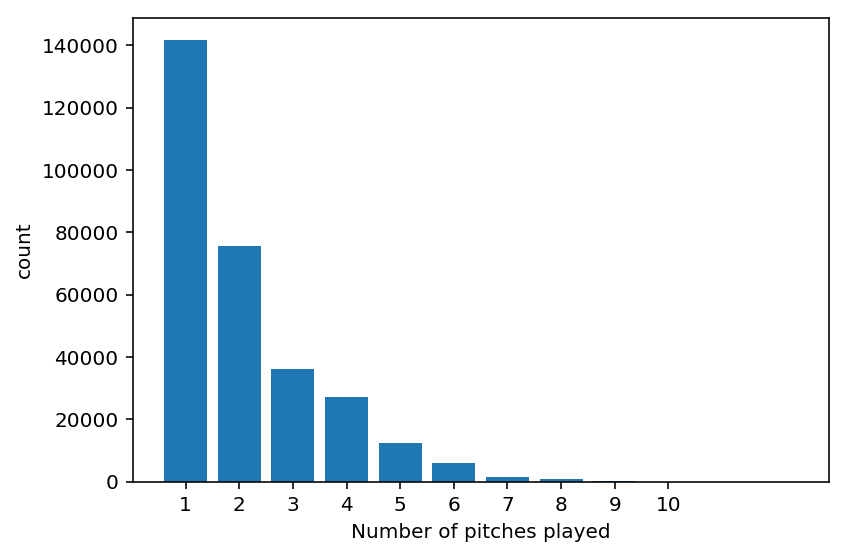

In [130]:
x,y=np.unique(numNotes,return_counts=True)
plt.bar(x,y)
plt.xticks(np.arange(1,11))
plt.xlabel('Number of pitches played')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('figures/pitchesPlayed.png')

## Number of notes per offset

In [6]:
nps=[]

for song in tqdm.tqdm(songs):
    npsHere=notes_per_song(song)
    nps.append(len(np.unique(npsHere)))



100%|████████████████████████████████████████| 266/266 [26:33<00:00,  2.32s/it]


In [9]:
x,y=np.unique(nps,return_counts=True)

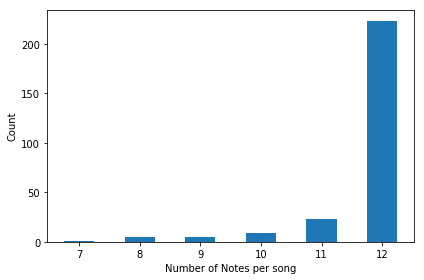

In [14]:
plt.bar(x,y,width=0.5)
plt.xlabel("Number of Notes per song")
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/nps_data.png')

## Pitches distribution

In [12]:
def get_pitches(filename):
    """Returns all the pitches played in the midi file with repetition"""
    #note stream is not neccesarily in order of increasing offset.
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes

    pitches=[]
    
    for note in notesRaw:
        if isinstance(note,music21.note.Note):
            pitches.append(note.pitch.midi)
        else:
            chordNotes=[int(b.midi) for b in note.pitches]
            pitches.extend(chordNotes)

    
    return pitches

In [13]:
pitches=[]

for song in tqdm.tqdm(songs):
    pHere=get_pitches(song)
    pitches.extend(pHere)



100%|██████████| 266/266 [02:03<00:00,  1.18s/it]


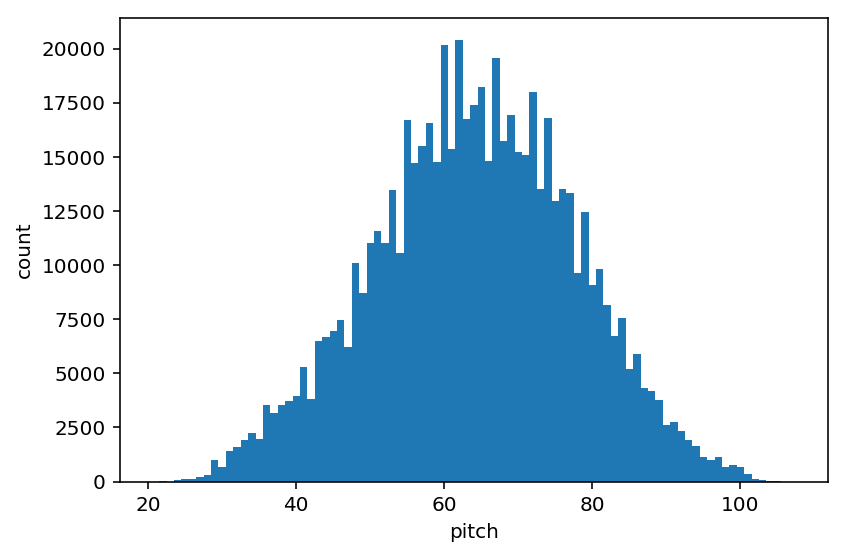

In [22]:
x,y=np.unique(pitches,return_counts=True)
plt.bar(x,y,width=1)
plt.xlabel('pitch')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('figures/pitchDist.png')
plt.show()

In [25]:
np.percentile(pitches,[0.5,99.5])

array([31., 97.])

## Encoding To Sequences

In [2]:
def encode_song(filename):
    """Encodes song in filename. See milestone1 report for encoding"""
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes

    pitches=[]
    offsets=[]
    
    for note in notesRaw:
        if isinstance(note,music21.note.Note):
            pitches.append(note.pitch.midi)
            offsets.append(note.offset)
        else:
            chordNotes=[int(b.midi) for b in note.pitches]
            pitches.extend(chordNotes)
            offsets.extend([note.offset]*len(chordNotes))

    pitches=np.array(pitches)
    offsets=np.array(offsets)
    uniqueSortedOffsets=np.sort(np.unique(offsets))
    
    encoding=[]
    
    for i in range(len(uniqueSortedOffsets)-1):
        time=uniqueSortedOffsets[i]
        pitchesHere=pitches[offsets==time]
        goforward='gf'+str(uniqueSortedOffsets[i+1]-time)
        
        encoding.extend(list(np.sort(pitchesHere)))
        encoding.append(goforward)
        
        
    
    return encoding   

In [3]:
encoding=encode_song('Music/beeth/elise.mid')

In [4]:
encoding

[76,
 'gf0.25',
 75,
 'gf0.25',
 76,
 'gf0.25',
 75,
 'gf0.25',
 76,
 'gf0.25',
 71,
 'gf0.25',
 74,
 'gf0.25',
 72,
 'gf0.25',
 45,
 69,
 'gf0.25',
 52,
 'gf0.25',
 57,
 'gf0.25',
 60,
 'gf0.25',
 64,
 'gf0.25',
 69,
 'gf0.25',
 40,
 71,
 'gf0.25',
 52,
 'gf0.25',
 56,
 'gf0.25',
 64,
 'gf0.25',
 68,
 'gf0.25',
 71,
 'gf0.25',
 45,
 72,
 'gf0.25',
 52,
 'gf0.25',
 57,
 'gf0.25',
 64,
 'gf0.25',
 76,
 'gf0.25',
 75,
 'gf0.25',
 76,
 'gf0.25',
 75,
 'gf0.25',
 76,
 'gf0.25',
 71,
 'gf0.25',
 74,
 'gf0.25',
 72,
 'gf0.25',
 45,
 69,
 'gf0.25',
 52,
 'gf0.25',
 57,
 'gf0.25',
 60,
 'gf0.25',
 64,
 'gf0.25',
 69,
 'gf0.25',
 40,
 71,
 'gf0.25',
 52,
 'gf0.25',
 56,
 'gf0.25',
 64,
 'gf0.25',
 72,
 'gf0.25',
 71,
 'gf0.25',
 45,
 69,
 'gf0.25',
 52,
 'gf0.25',
 57,
 'gf0.5',
 76,
 'gf0.25',
 75,
 'gf0.25',
 76,
 'gf0.25',
 75,
 'gf0.25',
 76,
 'gf0.25',
 71,
 'gf0.25',
 74,
 'gf0.25',
 72,
 'gf0.25',
 45,
 69,
 'gf0.25',
 52,
 'gf0.25',
 57,
 'gf0.25',
 60,
 'gf0.25',
 64,
 'gf0.25',
 69,
 

In [39]:
encoding=encode_song('Music/debussy/DEB_CLAI.MID')

In [42]:
np.array(encoding[0:20])

array(['65', '68', 'gf0.5', '77', '80', 'gf2.0', '73', '77', 'gf1.5',
       '66', '69', 'gf0.5', '72', '75', 'gf0.5', '73', '77', 'gf0.5',
       '72', '75'], dtype='<U21')

In [45]:
def decode_song(song,filename):
    """Decodes song encoded by encode_song(). song is an encoded song of type list, and filename is
    the path where the new decoded midi file is to reside"""
    stream=[]
    offset=0
    for event in song:
        if 'gf' in str(event):
            offset+=float(event[2:])
        else:
            newNote=music21.note.Note(int(event))
            newNote.offset=offset
            newNote.storedInstrument=music21.instrument.Piano()
            stream.append(newNote)
    midi_stream=music21.stream.Stream(stream)
    midi_stream.write('midi', fp=filename)
    return 1
    
    
    

In [46]:
encoding=encode_song('Music/beeth/elise.mid')
decode_song(encoding,'Samples/encoded_decoded_fur_elise.mid')

1